In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [32]:
data = pd.read_csv('final project 2024.csv')

In [33]:
data

,period,demand
0,1,21
1,2,81
2,3,32
3,4,58
4,5,47
...,...,...
9995,9996,68
9996,9997,70
9997,9998,74
9998,9999,52


# `EDA`

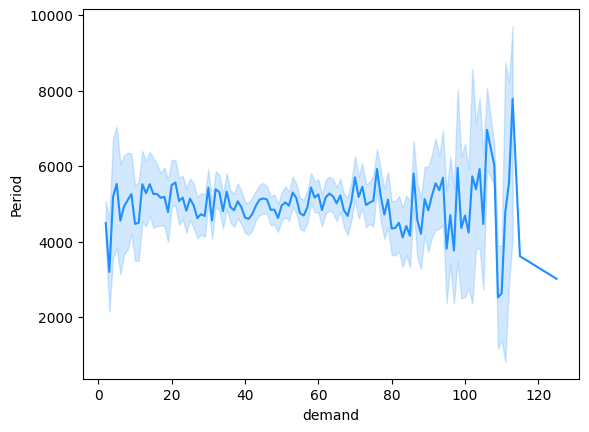

In [34]:
sns.lineplot(x='demand', y='period', data=data, color='dodgerblue')
plt.xlabel('demand')
plt.ylabel('Period')

plt.show()

In [35]:
data['date'] = pd.date_range(start='2023-01-01', periods=10000, freq='D')

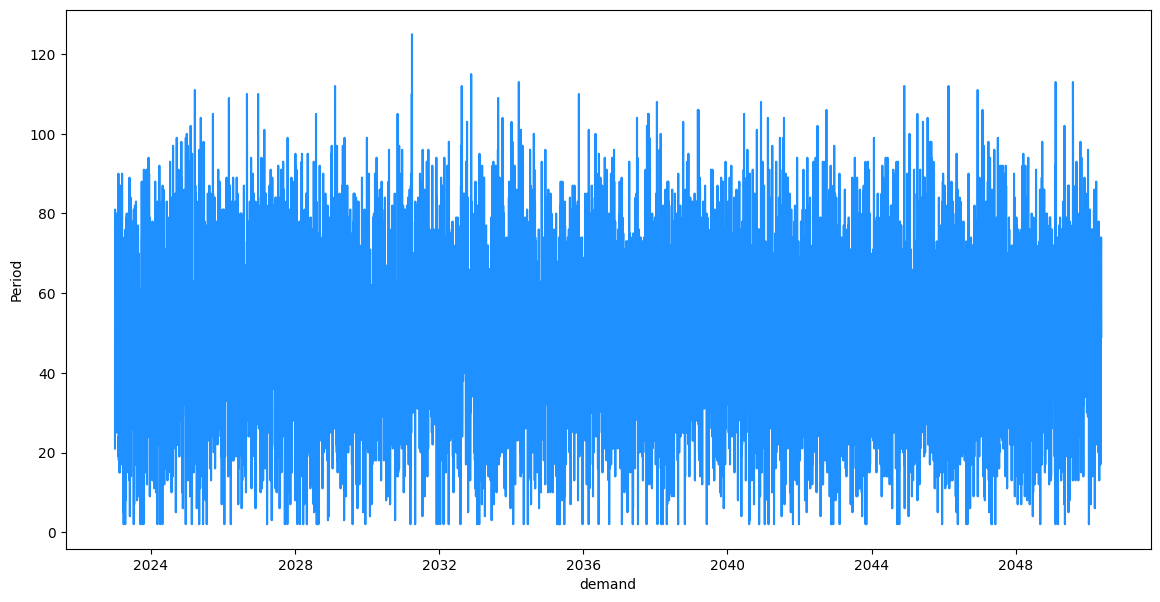

In [36]:
plt.figure(figsize=(14, 7))

sns.lineplot(x='date', y='demand', data=data, color='dodgerblue')
plt.xlabel('demand')
plt.ylabel('Period')

plt.show()

In [37]:
data['year_month'] = data['date'].dt.strftime('%Y-%m')

In [38]:
agg_data = data.groupby('year_month')['demand'].agg(np.sum).reset_index()

/var/folders/kx/gthdrm8j6mv55clq5hnmrnx40000gn/T/ipykernel_9422/1638428736.py:1: FutureWarning: The provided callable <function sum at 0x10490ac00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  agg_data = data.groupby('year_month')['demand'].agg(np.sum).reset_index()


[]

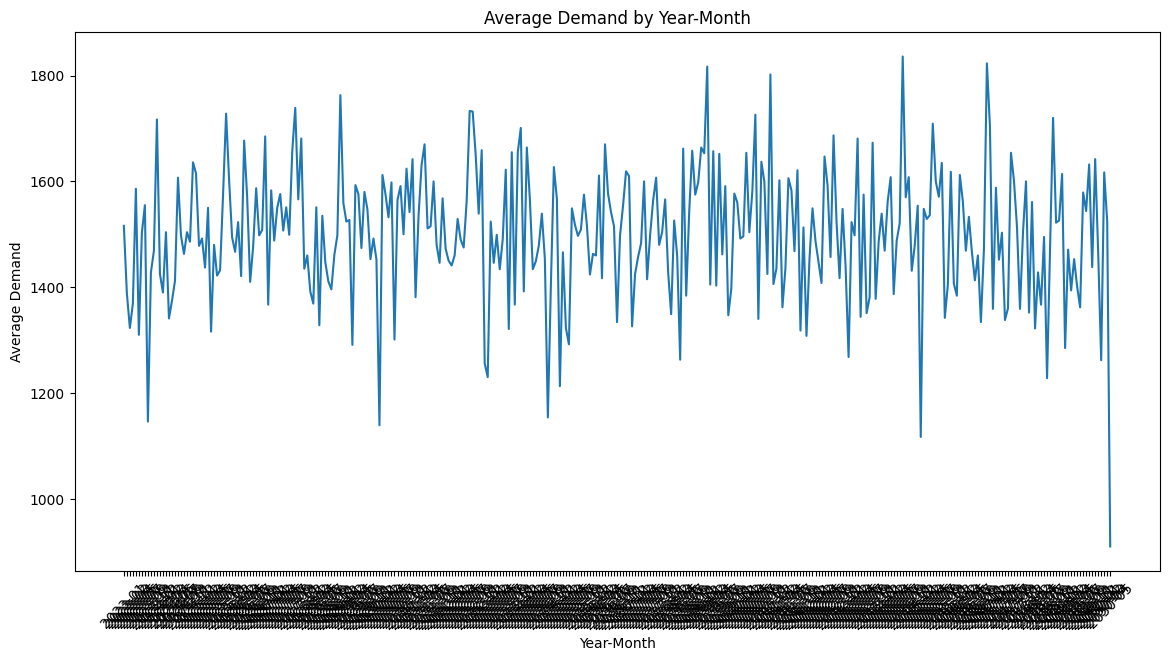

In [39]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=agg_data, x='year_month', y='demand')

plt.xlabel('Year-Month')
plt.ylabel('Average Demand')
plt.title('Average Demand by Year-Month')
plt.xticks(rotation=45)

plt.plot()

-------------------------------------------------------------------------------------------------------------------------------------

## `Demand Forecast`

#### train/test split 80:20

In [25]:
train_set = data[:600].copy()
test_set = data[600:800].copy()
oot_set = data[800:].copy()

In [26]:
from statsmodels.tsa.api import ExponentialSmoothing
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial):
    smoothing_level = trial.suggest_float('smoothing_level', 0.0, 0.9)
    smoothing_slope = trial.suggest_float('smoothing_slope', 0.01, 0.3)
    smoothing_seasonal = trial.suggest_float('smoothing_seasonal', 0.01, 0.3)
    
    # Fit the model with suggested parameters
    model = ExponentialSmoothing(
        train_set['demand'], 
        seasonal_periods=30, 
        trend='add', 
        seasonal='add',
        initialization_method="estimated"
    )
    fitted_model = model.fit(
        smoothing_level=smoothing_level, 
        smoothing_slope=smoothing_slope, 
        smoothing_seasonal=smoothing_seasonal,
        optimized=False  # Important to use False here because we're providing specific values
    )
    
    # Forecast the values and calculate an error metric
    forecast = fitted_model.forecast(steps=200)
    mse = mean_squared_error(test_set['demand'], forecast)
    
    return mse

In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

model = ExponentialSmoothing(pd.concat([train_set, test_set])['demand'], seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated")
fitted_model = model.fit(**study.best_params)

[I 2024-05-31 21:32:08,045] A new study created in memory with name: no-name-6b30e039-e8d0-478a-8f4e-4c31aabbcfe4
/var/folders/kx/gthdrm8j6mv55clq5hnmrnx40000gn/T/ipykernel_9422/218955612.py:18: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = model.fit(
[I 2024-05-31 21:32:08,057] Trial 0 finished with value: 635.1729643174036 and parameters: {'smoothing_level': 0.5931878973426564, 'smoothing_slope': 0.014364956169026746, 'smoothing_seasonal': 0.08958064152652938}. Best is trial 0 with value: 635.1729643174036.


/var/folders/kx/gthdrm8j6mv55clq5hnmrnx40000gn/T/ipykernel_9422/218955612.py:18: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = model.fit(
[I 2024-05-31 21:32:08,066] Trial 1 finished with value: 185966.60823504257 and parameters: {'smoothing_level': 0.8708002438148592, 'smoothing_slope': 0.2259085941014842, 'smoothing_seasonal': 0.17285370767770555}. Best is trial 0 with value: 635.1729643174036.
/var/folders/kx/gthdrm8j6mv55clq5hnmrnx40000gn/T/ipykernel_9422/218955612.py:18: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = model.fit(
[I 2024-05-31 21:32:08,076] Trial 2 finished with value: 5692.003527686877 and parameters: {'smoothing_level': 0.4052802899891931, 'smoothing_slope': 0.23920361959845707, 'smoothing_seasonal': 0.06038307158815857}. Best is trial 0 with value: 635.1729643174036.
/var/folders/kx/gthdrm8j6mv55clq5hnmrnx40000gn/T/ipykernel_9422/218955612.py

In [28]:
forescast = fitted_model.forecast(steps=200)
test_mse = mean_squared_error(test_set['demand'], forescast, squared=False)

print(f"Test MSE: {test_mse}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test MSE: 24.528672321461755


In [29]:
data['exponential_forecast'] = forescast

In [30]:
data

,period,demand,exponential_forecast
0,1,21,NaN
1,2,81,NaN
2,3,32,NaN
3,4,58,NaN
4,5,47,NaN
...,...,...,...
9995,9996,68,NaN
9996,9997,70,NaN
9997,9998,74,NaN
9998,9999,52,NaN


------------------------------------------------------------------------------------------------------------------------------------

## `Business Impact`

### Question 4